In [276]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [352]:
import pandas as pd
import numpy as np
import nltk
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.naive_bayes import MultinomialNB
from imblearn.metrics import classification_report_imbalanced
from sklearn import svm
from nltk.tokenize import TweetTokenizer
from Visualization import Visualization
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [242]:
data = pd.read_csv("rebtel_w_lexicon.csv")

In [326]:
# Define Vectorizer to build bag-of-words representation
#vectorizer = CountVectorizer(ngram_range=(2,2))
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))


vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None,   \
                             max_features = 245)



RANDOM_STATE = 0
seed = 18
np.random.seed(seed)

In [327]:
#ADD MORE FEATURES
add_feats = data[['r_negative', 'r_positive',
                'r_neutral','t_negative', 't_positive',
                't_neutral']]
a_feats = add_feats.values

In [343]:
#Select method to train model (Lems/Snow/Porter/Lanc)
method =  "Lanc"
add_feats = True
tfidf = False
 

x_fts = vectorizer.fit_transform(data[method + '_title_review'])

#x_fts = vectorizer.fit_transform(data['Rel_w_title_review'])

if tfidf:
    x_fts = tfidf_vectorizer.fit_transform(data[method + '_title_review'])
    
x_fts = x_fts.toarray()


if add_feats:
    x_fts = np.concatenate((x_fts,a_feats),axis=1)


np.random.seed(seed)

train_size = 0.65
train_size = int(len(x_fts)* train_size)
shuffle(data)

x_train, y_train = x_fts[0:train_size], data['Rating'][0:train_size]
X_test, Y_test = x_fts[train_size:], data['Rating'][train_size:]

In [353]:
#cross_validation = StratifiedShuffleSplit(y_data, n_iter=10, test_size=0.3, random_state=RANDOM_STATE)
cross_validation =   StratifiedKFold (y_train,n_folds=5, random_state=RANDOM_STATE)

scores = []
confusion_matrices = []
clf_models = []
avgs = []

for train_index,test_index in cross_validation:

    clf = None

    dx_train, dy_train = x_train[train_index], y_train[train_index]
    dx_test, dy_test = x_train[test_index], y_train[test_index]
    
    clf = RandomForestClassifier(n_estimators= 37, n_jobs=-1)
    #clf = svm.SVC(decision_function_shape='ovo',random_state=RANDOM_STATE,probability=True)
    clf.fit(dx_train, dy_train)
    clf_models.append(clf)
    
    # Saving the scores.
    test_score = clf.score(dx_test, dy_test)
    test_preds = clf.predict(dx_test)
    rep = classification_report_imbalanced(dy_test, test_preds)
    txt_rep = nltk.word_tokenize(rep[500:1000])
    avg_total = [float(txt_rep[i]) for i in range(3,len(txt_rep))]
    avgs.append(avg_total)
    scores.append(test_score)


    # Saving the confusion matrices.
    data_classes_pred = clf.predict(dx_test) 
    cm = confusion_matrix(dy_test, test_preds)
    confusion_matrices.append(cm)
    
print('Average precision :', str(np.mean([avgs[i][0] for i in range(len(avgs))])))
print('Average recall :', str(np.mean([avgs[i][1] for i in range(len(avgs))])))
print('Average F-score :', str(np.mean([avgs[i][3] for i in range(len(avgs))])))

/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/imblearn/metrics/classification.py:240: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)


Average precision : 0.528
Average recall : 0.57
Average F-score : 0.522


In [354]:
clf = RandomForestClassifier(n_estimators= 37, n_jobs=-1,random_state=RANDOM_STATE)
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=37, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [355]:
test_preds = clf.predict(X_test)

In [300]:
df = pd.DataFrame(test_preds,columns=['RFC_preds'])

In [262]:
n_df = pd.DataFrame(Y_test)
n_df = n_df.reset_index(True)

In [263]:
df['True_label'] = n_df['Rating']

In [356]:
print(classification_report_imbalanced(y_pred=test_preds,y_true=Y_test))


                   pre       rec       spe        f1       geo       iba       sup

          1       0.26      0.83      0.90      0.39      0.50      0.24        24
          2       0.00      0.00      1.00      0.00      0.00      0.00        31
          3       0.38      0.17      0.97      0.24      0.59      0.33        52
          4       0.35      0.24      0.86      0.29      0.53      0.26       148
          5       0.72      0.81      0.53      0.76      0.69      0.47       379

avg / total       0.55      0.59      0.68      0.56      0.60      0.38       634



In [357]:
clf.score(X_test,Y_test)

0.58832807570977919

In [312]:
vis = Visualization()

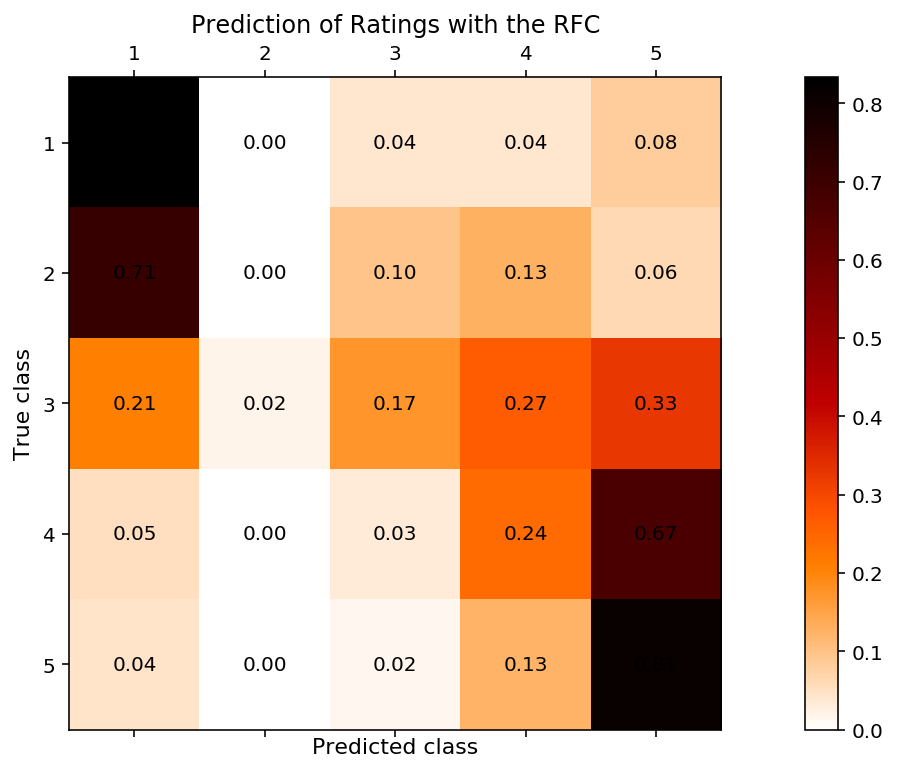

In [364]:
vis.plot_confusion_matrix(Y_test, test_preds, 
                          'Prediction of Ratings with the RFC')

In [362]:
predictions = pd.DataFrame(test_preds,columns=['RFC_pred'])
true = pd.DataFrame(Y_test)
true = true.reset_index()
predictions['True_label'] = true['Rating']
predictions.to_csv('RFC1_predictions.csv')

In [201]:
from sklearn.externals import joblib
joblib.dump(clf, 'RFC_best_model.pkl', compress=9)

['RFC_best_model.pkl']

In [359]:
clf = joblib.load('best_RFC_text_SKF.pkl')